
 INTEGRATED BANKING ANALYSIS 
--------------------------------------------------------------
1) Top-N Customers by Overall Banking Activity
2) Active Loans + Recent Transactions (last 6 months, by status)
3) Avg Income: Has Loan vs No Loan
4) Top Cities by Financial Activity
5) Inactive Loan Customers (no transactions in N months)
--------------------------------------------------------------


 Enter your choice Between (1–5):  5
Enter months of inactivity (e.g., 2, 6):  3



Loan customers with NO transactions in last 3 month(s)
------------------------------------------------------

 Showing first 5 and last 5 rows (data too large):

--------------------------------------------------------------
 customer_id       full_name  loan_id loan_status
           1    Anay Shanker     1171   Defaulted
           1    Anay Shanker     2845    Approved
           1    Anay Shanker     3599     Default
           6 Aaina Choudhary      514      Closed
           8     Rasha Kakar      651      Closed

...

 customer_id        full_name  loan_id loan_status
        4995       Nitya Ravi      181   Defaulted
        4995       Nitya Ravi     3328     Pending
        4996      Khushi Goel     3945      Active
        4997 Pranay Zachariah      710      Closed
        4998     Aarna Bhalla     1250      Closed

 Total rows: 3695


C:\Users\dines\AppData\Local\Temp\ipykernel_12388\2503319987.py:36: DeprecationWarning: Call to deprecated function stored_results. Reason: The property counterpart 'stored_results' will be added in a future release, and this method will be removed.
  for result in cursor.stored_results():


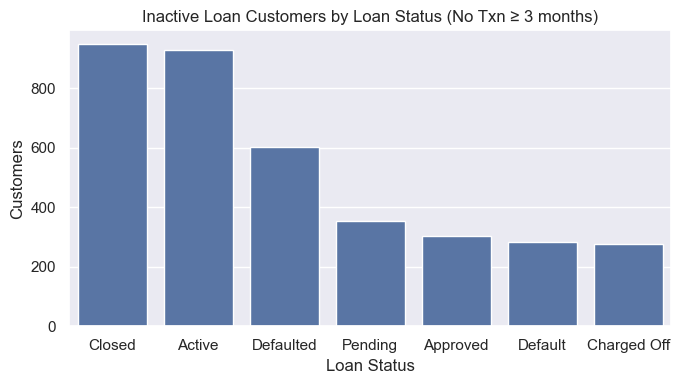

In [4]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mysql.connector import Error

# -----------------------------
# DB config
# -----------------------------
db_config = {
    "host": "localhost",
    "user": "root",
    "password": "14032002kD@",
    "database": "Banking"
}

# -----------------------------
# Stored proc runner
# -----------------------------
def run_proc(proc_name, params=None):
    """
    Execute stored procedure and return (df, updated_params).
    Pass OUT params inside a LIST so MySQL connector can write back.
    """
    conn = None
    try:
        conn = mysql.connector.connect(**db_config)
        cursor = conn.cursor()

        if params is not None:
            cursor.callproc(proc_name, params)
        else:
            cursor.callproc(proc_name)

        df = None
        for result in cursor.stored_results():
            rows = result.fetchall()
            cols = [c[0] for c in result.description]
            df = pd.DataFrame(rows, columns=cols)
        return df, params
    
    except Error as e:
        print(f" Error running {proc_name}: {e}")
        return None, params
    finally:
        try:
            cursor.close()
        except:
            pass
        if conn and conn.is_connected():
            conn.close()


# -----------------------------
# Visualization + Table Helpers
# -----------------------------
def show_table(df, title=None):
    if title:
        print(f"\n{title}\n" + "-" * len(title))
        
    if df is None or df.empty:
        print(" No rows.")
        return

    total_rows = len(df)

    if total_rows <= 10:
        print(df.to_string(index=False))
    else:
        print("\n Showing first 5 and last 5 rows (data too large):\n")
        print("--------------------------------------------------------------")
        print(df.head(5).to_string(index=False))
        print("\n...\n")
        print(df.tail(5).to_string(index=False))
        print(f"\n Total rows: {total_rows}")

def topn_overall_viz(df, top_n):
    show_table(df, f"Top {top_n} Customers (Transactions + Loans + Overall)")
    if df is None or df.empty:
        return
    
    plt.figure(figsize=(10,5))
    sns.barplot(data=df, x="full_name", y="overall_value")
    plt.title(f"Top {top_n} Customers by Overall Banking Activity")
    plt.xlabel("Customer")
    plt.ylabel("Overall Value (₹)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

def active_recent_viz(df, total_count, status):
    show_table(df, f"Customers with '{status}' Loans & Transactions in last 6 months")
    if df is None or df.empty:
        return

    s = df["loan_status"].value_counts().reset_index()
    s.columns = ["loan_status", "count"]

    plt.figure(figsize=(7,4))
    sns.barplot(data=s, x="loan_status", y="count")
    plt.title(f"Customers with '{status}' Loans & Recent Transactions")
    plt.xlabel("Loan Status")
    plt.ylabel("Customers")
    plt.tight_layout()
    plt.show()

def avg_income_viz(df):
    show_table(df, "Average Income: Has Loan vs No Loan")
    if df is None or df.empty:
        return

    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x="loan_status", y="avg_income")
    plt.title("Avg Income by Category (Loan vs No-Loan)")
    plt.xlabel("Category")
    plt.ylabel("Avg Income (₹)")
    plt.tight_layout()
    plt.show()

def top_cities_viz(df):
    show_table(df, "Top 5 Cities by Combined Financial Activity")
    if df is None or df.empty:
        return

    plt.figure(figsize=(9,4.5))
    sns.barplot(data=df, x="city", y="combined_total")
    plt.title("Top 5 Cities by Combined Value (Transactions + Loans)")
    plt.xlabel("City")
    plt.ylabel("Combined Value (₹)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

def inactive_loan_viz(df, months):
    show_table(df, f"Loan customers with NO transactions in last {months} month(s)")
    if df is None or df.empty:
        return

    agg = df["loan_status"].value_counts().reset_index()
    agg.columns = ["loan_status", "count"]

    plt.figure(figsize=(7,4))
    sns.barplot(data=agg, x="loan_status", y="count")
    plt.title(f"Inactive Loan Customers by Loan Status (No Txn ≥ {months} months)")
    plt.xlabel("Loan Status")
    plt.ylabel("Customers")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Interactive menu
# -----------------------------
def main():
    print("\n INTEGRATED BANKING ANALYSIS ")
    print("--------------------------------------------------------------")
    print("1) Top-N Customers by Overall Banking Activity")
    print("2) Active Loans + Recent Transactions (last 6 months, by status)")
    print("3) Avg Income: Has Loan vs No Loan")
    print("4) Top Cities by Financial Activity")
    print("5) Inactive Loan Customers (no transactions in N months)")
    print("--------------------------------------------------------------")

    choice = input(" Enter your choice Between (1–5): ").strip()

    if choice == "1":
        top_n = int(input("Enter N (e.g., 10): ").strip())
        df, _ = run_proc("topn_customers_activity", [top_n])
        if df is not None and not df.empty:
            topn_overall_viz(df, top_n)
        else:
            print(" No data returned.")

    elif choice == "2":
        status = input("Enter loan status (active/approved/pending/closed/defaulted/etc.): ").title().strip()
        params = [status, 0]  # OUT param at index 1
        df, updated = run_proc("active_loan_recent_transactions", params)
        total = updated[1] if updated else 0
        if df is not None and not df.empty:
            active_recent_viz(df, total, status)
        else:
            print(f" No customers found for '{status}' in last 6 months. OUT total={total}")

    elif choice == "3":
        df, _ = run_proc("avg_income_vs_loan_status")
        if df is not None and not df.empty:
            avg_income_viz(df)
        else:
            print(" No data returned.")

    elif choice == "4":
        df, _ = run_proc("top_cities_by_financial_activity")
        if df is not None and not df.empty:
            top_cities_viz(df)
        else:
            print(" No data returned.")

    elif choice == "5":
        months = int(input("Enter months of inactivity (e.g., 2, 6): ").strip())
        df, _ = run_proc("inactive_loan_customers", [months])
        if df is not None and not df.empty:
            inactive_loan_viz(df, months)
        else:
            print(f" No inactive customers for ≥ {months} month(s).")

    else:
        print(" Invalid choice. Please enter 1–5 only.")


if __name__ == "__main__":
    sns.set_theme()
    main()
